# Module 4 Part 4

## Data Prep

In [1]:
# Import necessary libraries for Adaboost implementation
import numpy as np
from sklearn.tree import DecisionTreeClassifier  # Weak learner for classification
from sklearn.base import clone  # Used to create copies of the base learner
import matplotlib.pylab as plt 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

In [2]:
class AdaBoost:
    def __init__(self, n_learners=20, base=DecisionTreeClassifier(max_depth=1), random_state=1234):
        """
        Create a new adaboost classifier.
        
        Args:
            N (int, optional): Number of weak learners in classifier.
            base (BaseEstimator, optional): Your general weak learner 
            random_state (int, optional): set random generator.  needed for unit testing. 

        Attributes:
            base (estimator): Your general weak learner 
            n_learners (int): Number of weak learners in classifier.
            alpha (ndarray): Coefficients on weak learners. 
            learners (list): List of weak learner instances. 
        """
        
        np.random.seed(random_state)
        
        self.n_learners = n_learners 
        self.base = base
        # alpha[k] stores the weight/vote of the kth weak learner
        self.alpha = np.zeros(self.n_learners)
        # learners stores the trained weak learner models
        self.learners = []
        
    def fit(self, X_train, y_train):
        """
        Train AdaBoost classifier on data. Sets alphas and learners. 
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """

        # =================================================================
        # TODO 

        # Note: You can create and train a new instantiation 
        # of your sklearn decision tree as follows 

        # w = np.ones(len(y_train))
        # h = clone(self.base)
        # h.fit(X_train, y_train, sample_weight=w)

        # Intitialize weights uniformly: each example has equal weights
        w = np.ones(len(y_train)) / len(y_train)

        # Train n_learners weak learners
        for k in range(self.n_learners):
            # a) Create a new weak learner and trian it with current weights
            h = clone(self.base)
            h.fit(X_train, y_train, sample_weight = w)

            # Get preditctions from this weak learner
            predictions = h.predict(X_train)

            # b) Compute the weighted error: sum of weights where prediciton is wrong 
            misclassified = (predictions != y_train)
            err_k = np.sum(w[misclassified]) / np.sum(w)

            # Avoid division by zero and log of zero 
            err_k = np.clip(err_k, 1e-10, 1-1e-10)

            # c) Compute vote weight alpha_k = -0.5 * ln((1 - err_k)/ err_k)
            alpha_k = 0.5 * np.log((1 - err_k) /  err_k)

            # Store the learner and its weight
            self.learners.append(h)
            self.alpha[k] = alpha_k

            # d) Update training example weights: w[i] *= exp(-alpha_k * y[i] * h(x[i]))
            w = w * np.exp(-alpha_k * y_train * predictions)

            # e) Normalize weights to sum to 1
            w = w / np.sum(w)



        # =================================================================
            
    def predict(self, X):
        """
        Adaboost prediction for new data X.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns: 
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """

        # =================================================================
        # TODO 

        # Initialize predictions to zero
        yhat = np.zeros(X.shape[0])

        # Sum the weighted votes from all the learners
        for a, h, in zip(self.alpha, self.learners):
            yhat += a * h.predict(X)

        # Return the sighn of the weighted sum: +1 or -1
        return np.sign(yhat)
        # =================================================================
    
    def score(self, X, y):
        """
        Computes prediction accuracy of classifier.  
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            Prediction accuracy (between 0.0 and 1.0).
        """
        pred = self.predict(X)
        # Accuracy = fraction of correctly classified examples
        return np.sum(y == pred)/len(y)
    
    def staged_score(self, X, y):
        """
        Computes the ensemble score after each iteration of boosting 
        for monitoring purposes, such as to determine the score on a 
        test set after each boost.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            scores (ndarary): [n_learners] ndarray of scores 
        """

        scores = []
        
        # Accumulate weighted predictions across all learners
        yhat = np.zeros(X.shape[0])
        for a, h in zip(self.alpha, self.learners):
            # Add each learner's weighted vote to the cumulative prediction
            yhat += a * h.predict(X)
            # Compute accuracy after adding this learner
            scores.append(np.sum(np.sign(yhat)==y)/len(y))
            
        return np.array(scores)
    
    def staged_margin(self, x, y):
        """
        Computes the staged margin after each iteration of boosting 
        for a single training example x and true label y
        
        Args:
            x (ndarray): [n_features] ndarray of data 
            y (integer): an integer {-1,1} representing the true label of x 
            
        Returns: 
            margins (ndarary): [n_learners] ndarray of margins 
        """
        
        # Normalize alphas to sum to 1 for margin computation
        norm_alphas = self.alpha / np.sum(self.alpha)
        
        margins = np.zeros(self.n_learners)
        for kk, h in enumerate(self.learners):
            # Compute contribution: positive if correct prediction, negative if wrong
            contrib = (-1.0)**((h.predict([x]) == y)+1) * norm_alphas[kk]
            if kk == 0:
                margins[kk] = contrib 
            else:
                # Accumulate margin over all learners up to kk
                margins[kk] = margins[kk-1] + contrib
       
        return margins

In [3]:
# Load the daily climate data 
climate_daily = pd.read_csv("fires_climate_daily.csv")

print(f"Dataset size: {len(climate_daily)} rows")
print("\nDataset info:")
climate_daily.info()

# Convert date column
climate_daily['acq_date'] = pd.to_datetime(climate_daily['acq_date'])

Dataset size: 2465 rows

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2465 entries, 0 to 2464
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   acq_date               2465 non-null   object 
 1   fire_count             2465 non-null   int64  
 2   mean_frp               2465 non-null   float64
 3   soil_temp_level_1      11 non-null     float64
 4   soil_moisture_level_1  11 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 96.4+ KB


In [4]:
# Basic temporal features
climate_daily['day_of_year'] = climate_daily['acq_date'].dt.dayofyear
climate_daily['month'] = climate_daily['acq_date'].dt.month
climate_daily['quarter'] = climate_daily['acq_date'].dt.quarter
climate_daily['week'] = climate_daily['acq_date'].dt.isocalendar().week

# Sort by date to ensure proper rolling calculations
climate_daily = climate_daily.sort_values('acq_date').reset_index(drop=True)

# Create rolling statistics (7-day window)
climate_daily['fire_count_7day_avg'] = climate_daily['fire_count'].rolling(window=7, min_periods=1).mean()
climate_daily['frp_7day_avg'] = climate_daily['mean_frp'].rolling(window=7, min_periods=1).mean()

# Create lagged features (yesterday's values)
climate_daily['fire_count_lag1'] = climate_daily['fire_count'].shift(1)
climate_daily['frp_lag1'] = climate_daily['mean_frp'].shift(1)

# Create target: predict high fire risk days (top 25% of fire counts)
fire_threshold = climate_daily['fire_count'].quantile(0.75)
climate_daily['high_fire_day'] = np.where(climate_daily['fire_count'] > fire_threshold, 
                                          'high', 'low')

print(f"\nFire count threshold (75th percentile): {fire_threshold:.2f}")
print(f"High fire days: {(climate_daily['high_fire_day'] == 'high').sum()}")
print(f"Low fire days: {(climate_daily['high_fire_day'] == 'low').sum()}")

# Drop rows with NaN from lagging (first row will have NaN)
climate_daily_clean = climate_daily.dropna(subset=['fire_count_lag1', 'frp_lag1'])

print(f"\nDataset size after cleaning: {len(climate_daily_clean)} samples")



Fire count threshold (75th percentile): 24.00
High fire days: 518
Low fire days: 1947

Dataset size after cleaning: 2464 samples


## AdaBoost Implementation

In [5]:
# Features and target variable
# Use yesterday's data + temporal features to predict today's risk
feature_columns = ['day_of_year', 'month', 'week', 
                   'fire_count_lag1', 'frp_lag1', 
                   'fire_count_7day_avg', 'frp_7day_avg']

X = climate_daily_clean[feature_columns].values
y = np.where(climate_daily_clean['high_fire_day'] == 'high', 1, -1)

print(f"\nFeatures shape: {X.shape}")
print(f"Target distribution: High (+1): {(y == 1).sum()}, Low (-1): {(y == -1).sum()}")
print(f"Class balance: {(y == 1).sum() / len(y) * 100:.1f}% high fire days")



Features shape: (2464, 7)
Target distribution: High (+1): 518, Low (-1): 1946
Class balance: 21.0% high fire days


In [6]:
# Split data - stratify to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Train high fire days: {(y_train == 1).sum()}")
print(f"Test high fire days: {(y_test == 1).sum()}")

# Scale features
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)


Train set size: 1971
Test set size: 493
Train high fire days: 414
Test high fire days: 104


In [7]:
# Train model
ada = AdaBoost(n_learners=50, base=DecisionTreeClassifier(max_depth=1), random_state=42)
ada.fit(X_train_scaled, y_train)

In [10]:
# Performance metrics

train_acc = ada.score(X_train_scaled, y_train)
test_acc = ada.score(X_test_scaled, y_test)

print(f"\nAdaBoost Training Accuracy: {train_acc:.4f}")
print(f"AdaBoost Test Accuracy: {test_acc:.4f}")

# Get predictions for confusion matrix analysis
y_train_pred = ada.predict(X_train_scaled)
y_test_pred = ada.predict(X_test_scaled)

# Calculate precision and recall manually
def calculate_metrics(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == -1) & (y_pred == 1))
    tn = np.sum((y_true == -1) & (y_pred == -1))
    fn = np.sum((y_true == 1) & (y_pred == -1))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {'precision': precision, 'recall': recall, 'f1': f1, 
            'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn}

train_metrics = calculate_metrics(y_train, y_train_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

print(f"\nTest Set Metrics:")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  F1-Score: {test_metrics['f1']:.4f}")


AdaBoost Training Accuracy: 0.8813
AdaBoost Test Accuracy: 0.8824

Test Set Metrics:
  Precision: 0.8026
  Recall: 0.5865
  F1-Score: 0.6778


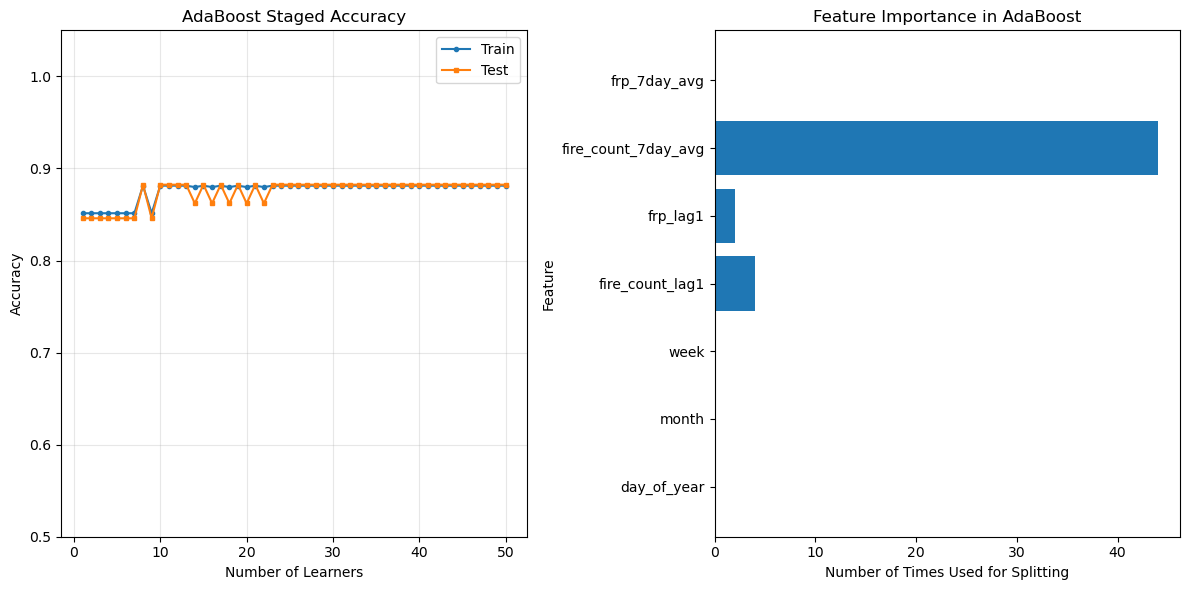

In [11]:
# Plot accuracy

train_scores = ada.staged_score(X_train_scaled, y_train)
test_scores = ada.staged_score(X_test_scaled, y_test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_scores)+1), train_scores, label='Train', marker='o', markersize=3)
plt.plot(range(1, len(test_scores)+1), test_scores, label='Test', marker='s', markersize=3)
plt.xlabel('Number of Learners')
plt.ylabel('Accuracy')
plt.title('AdaBoost Staged Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.5, 1.05])



plt.subplot(1, 2, 2)

# Count how many times each feature is used for splitting
feature_usage = np.zeros(len(feature_columns))
for learner in ada.learners:
    if hasattr(learner, 'tree_'):
        split_feature = learner.tree_.feature[0]
        if split_feature >= 0:  # Valid feature (not a leaf)
            feature_usage[split_feature] += 1

plt.barh(feature_columns, feature_usage)
plt.xlabel('Number of Times Used for Splitting')
plt.ylabel('Feature')
plt.title('Feature Importance in AdaBoost')
plt.tight_layout()

plt.show()


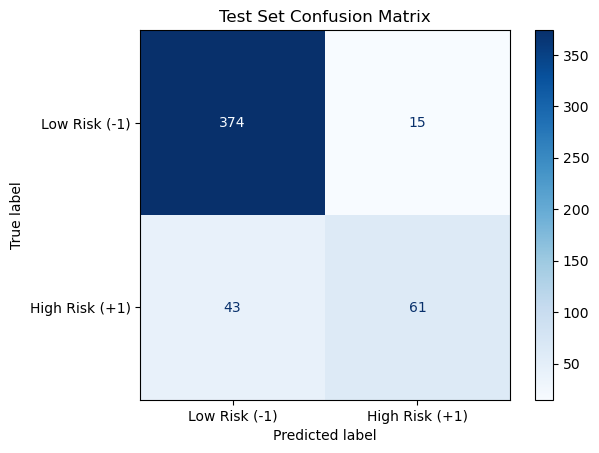

In [12]:
# Get predictions
y_test_pred = ada.predict(X_test_scaled)

# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[-1, 1])

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                               display_labels=['Low Risk (-1)', 'High Risk (+1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Test Set Confusion Matrix')
plt.show()